In [ ]:
%pip install sentence_transformers datasets cohere pinecone tqdm

In [60]:
from sentence_transformers import SentenceTransformer
from datasets import load_dataset, concatenate_datasets
from pinecone import Pinecone, ServerlessSpec
import os
from tqdm import tqdm
import cohere
import numpy as np
import warnings
from IPython.display import display
warnings.filterwarnings("ignore")

In [61]:
COHERE_API_KEY = "YOUR_API_KEY"
PINECONE_API_KEY = "YOUR_API_KEY"

**Model loading**

In [62]:
EMBEDDING_MODEL = 'all-MiniLM-L6-v2'
model = SentenceTransformer(EMBEDDING_MODEL)

#Load, chunk and embedd the dataset

In [63]:
ds = load_dataset("Ateeqq/news-title-generator")
print(ds['train'])

Dataset({
    features: ['summary', 'text'],
    num_rows: 98400
})


**Documents chunking method**

In [68]:
def chunk_documents(documents, max_chunk_length=400, stride=150):
    """
    Chunk documents into smaller pieces based on max_chunk_length and stride.
    Args:
        documents: List of documents (strings) to chunk.
        max_chunk_length: Maximum length of each chunk.
        stride: Stride to move the chunk window.
    Returns:
        List of chunked documents.
    """
    chunked_docs = []

    for doc in documents:
        doc_len = len(doc)
        if doc_len <= max_chunk_length:
            chunked_docs.append(doc)
        else:
            start = 0
            while start < doc_len:
                end = min(start + max_chunk_length, doc_len)
                chunk = doc[start:end]
                chunked_docs.append(chunk)
                start += stride

    return chunked_docs

**Dataset loading, chunking and embedding method**

In [69]:
def load_and_embedd_dataset(
        dataset_name: str = 'Ateeqq/news-title-generator',
        split: str = 'train',
        model: SentenceTransformer = SentenceTransformer('all-MiniLM-L6-v2'),
        text_field: str = 'text',
        max_chunk_length: int = 450,
        stride: int = 150,
        rec_num: int = 5000
) -> tuple:
    """
    Load a dataset and embedd the text field using a sentence-transformer model
    Args:
        dataset_name: The name of the dataset to load
        split: The split of the dataset to load
        model: The model to use for embedding
        text_field: The field in the dataset that contains the text
        max_chunk_length: Maximum length of each chunk.
        stride: Stride to move the chunk window.
        rec_num: The number of records to load and embedd
    Returns:
        tuple: A tuple containing the dataset and the embeddings
    """
    from datasets import load_dataset

    print("Loading and embedding the dataset")

    # Load the dataset
    dataset = load_dataset(dataset_name, split=split)

    # Print the number of records loaded
    print(f"Loaded {len(dataset[text_field])} records")

    # Chunk the documents
    documents = dataset[text_field][:rec_num]
    chunked_docs = chunk_documents(documents, max_chunk_length, stride)

    # Embed the first `rec_num` rows of the dataset
    embeddings = model.encode(chunked_docs)

    print("Done!")
    return dataset, embeddings, chunked_docs

**PinconeDB index creation method**

In [71]:
def create_pinecone_index(
        index_name: str,
        dimension: int,
        metric: str = 'cosine',
):
    """
    Create a pinecone index if it does not exist
    Args:
        index_name: The name of the index
        dimension: The dimension of the index
        metric: The metric to use for the index
    Returns:
        Pinecone: A pinecone object which can later be used for upserting vectors and connecting to VectorDBs
    """
    from pinecone import Pinecone, ServerlessSpec
    print("Creating a Pinecone index...")
    pc = Pinecone(api_key=PINECONE_API_KEY)
    existing_indexes = [index_info["name"] for index_info in pc.list_indexes()]
    if index_name not in existing_indexes:
        pc.create_index(
            name=index_name,
            dimension=dimension,
            # Remember! It is crucial that the metric you will use in your VectorDB will also be a metric your embedding
            # model works well with!
            metric=metric,
            spec=ServerlessSpec(
                cloud="aws",
                region="us-east-1"
            )
        )
    print("Done!")
    return pc

**Upsert vectors method (Update and insert to pinconeDB)**

In [79]:
def upsert_vectors(
        index: Pinecone,
        embeddings: np.ndarray,
        chunked_docs: list,
        text_field: str = 'text',
        batch_size: int = 128
):
    """
    Upsert vectors to a Pinecone index.
    Args:
        index: The Pinecone index object.
        embeddings: The embeddings to upsert.
        chunked_docs: The chunked documents.
        batch_size: The batch size to use for upserting.
    Returns:
        An updated Pinecone index.
    """
    print("Upserting the embeddings to the Pinecone index...")
    shape = embeddings.shape

    ids = [str(i) for i in range(shape[0])]
    meta = [{text_field: text} for text in chunked_docs]

    # create list of (id, vector, metadata) tuples to be upserted
    to_upsert = list(zip(ids, embeddings, meta))

    for i in tqdm(range(0, shape[0], batch_size)):
        i_end = min(i + batch_size, shape[0])
        index.upsert(vectors=to_upsert[i:i_end])
    return index

In [70]:
DATASET_NAME = 'Ateeqq/news-title-generator'

# Get the dataset, embeddings and chunked docs
dataset, embeddings, chunked_docs = load_and_embedd_dataset(
    dataset_name=DATASET_NAME,
    rec_num=5000,
    model=model,
    max_chunk_length=400,
    stride=150,
)
shape = embeddings.shape

Loading and embedding the dataset
Loaded 98400 records
Done!


In [73]:
# View of the dataset
pd_dataset = dataset.to_pandas()
pd_dataset.head(5)

,summary,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [83]:
INDEX_NAME = 'news-title-generator'

# Create the vector database
pc = create_pinecone_index(INDEX_NAME, shape[1])
index = pc.Index(INDEX_NAME)
index_upserted = upsert_vectors(index, embeddings, chunked_docs)

Creating a Pinecone index...
Done!
Upserting the embeddings to the Pinecone index...


100%|██████████| 41/41 [00:20<00:00,  1.98it/s]


In [84]:
# Get details about our index
index.describe_index_stats()

{'dimension': 384,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 5148}},
 'total_vector_count': 5148}

In [85]:
print(f"The embeddings shape: {embeddings.shape}")

The embeddings shape: (5148, 384)


**Augmenting LLM to the pipeline**

In [96]:
def augment_prompt(
        query: str,
        model: SentenceTransformer = SentenceTransformer('all-MiniLM-L6-v2'),
        index=None,
) -> str:
    """
    Augment the prompt with the top 3 results from the knowledge base.
    Args:
        query: The query to augment.
        index: The vectorstore object.
    Returns:
        str: The augmented prompt.
    """
    results = [float(val) for val in list(model.encode(query))]

    # get top 3 results from knowledge base
    query_results = index.query(
        vector=results,
        top_k=3,
        include_values=True,
        include_metadata=True
    )['matches']
    text_matches = [match['metadata']['text'] for match in query_results]

    # get the text from the results
    source_knowledge = "\n\n".join(text_matches)

    # feed into an augmented prompt
    augmented_prompt = f"""Using the contexts below, answer the query. You must only use the context given to you.
    Contexts:
    {source_knowledge}
    If the answer is not included in the source knowledge - say that you don't know.
    Query: {query}"""
    return augmented_prompt, source_knowledge

In [101]:
# Query example with RAG
query = "how many coins did Pranav Kaushik spend on CRED?"
augmented_prompt, source_knowledge = augment_prompt(query, model=model, index=index)

response_rag = co.chat(
    model='command-r-plus',
    message=augmented_prompt,
)

print(f'Response of the model using the RAG pipeline :')
print("=" * 20)
print(response_rag.text)
print("=" * 20)
print("\n")

# Query example without RAG
response_no_rag = co.chat(
        model='command-r-plus',
        message=query,
    )
print(f'Response of the model without RAG pipeline :')
print("=" * 20)
print(response_no_rag.text)
print("=" * 20)

Response of the model using the RAG pipeline :
2000 CRED coins.


Response of the model without RAG pipeline :
As an AI language model, I don't have access to real-time information about Pranav Kaushik's spending habits on CRED or any other platform. CRED is a mobile app that lets users pay credit card bills and earn rewards. It's possible that Pranav Kaushik has shared his experience with CRED on social media or other public forums, but I don't have specific information about the number of coins he has spent on the platform. If you have access to Pranav Kaushik's account on CRED, you can check his transaction history to get an idea of his spending habits and the number of coins he has earned or redeemed.


The original text from the dataset:

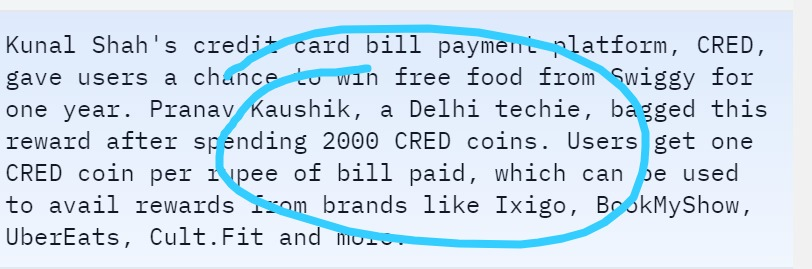

In [102]:
# Query example with RAG
query = """Who did call Modi "sir" 10 times?"""
augmented_prompt, source_knowledge = augment_prompt(query, model=model, index=index)

response_rag = co.chat(
    model='command-r-plus',
    message=augmented_prompt,
)

print(f'Response of the model using the RAG pipeline :')
print("=" * 20)
print(response_rag.text)
print("=" * 20)
print("\n")

# Query example without RAG
response_no_rag = co.chat(
        model='command-r-plus',
        message=query,
    )
print(f'Response of the model without RAG pipeline :')
print("=" * 20)
print(response_no_rag.text)
print("=" * 20)

Response of the model using the RAG pipeline :
Andhra Pradesh CM N Chandrababu Naidu


Response of the model without RAG pipeline :
US President Donald Trump


The original text from the dataset:

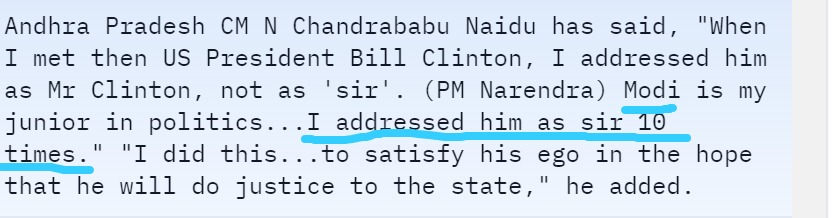

In [103]:
# Query example with RAG
query = """Who is the person that the Union Minister Dharmendra Pradhan claimed to be in control of the illegal mining mafia in Odisha?"""
augmented_prompt, source_knowledge = augment_prompt(query, model=model, index=index)

response_rag = co.chat(
    model='command-r-plus',
    message=augmented_prompt,
)

print(f'Response of the model using the RAG pipeline :')
print("=" * 20)
print(response_rag.text)
print("=" * 20)
print("\n")

# Query example without RAG
response_no_rag = co.chat(
        model='command-r-plus',
        message=query,
    )
print(f'Response of the model without RAG pipeline :')
print("=" * 20)
print(response_no_rag.text)
print("=" * 20)

Response of the model using the RAG pipeline :
Naveen Patnaik and Niranjan Patnaik.


Response of the model without RAG pipeline :
Union Minister Dharmendra Pradhan claimed that Biju Janata Dal (BJD) leader and former MP from Kandhamal, Pradip Kumar Majhi, was in control of the illegal mining mafia in Odisha.


The original text from the dataset:

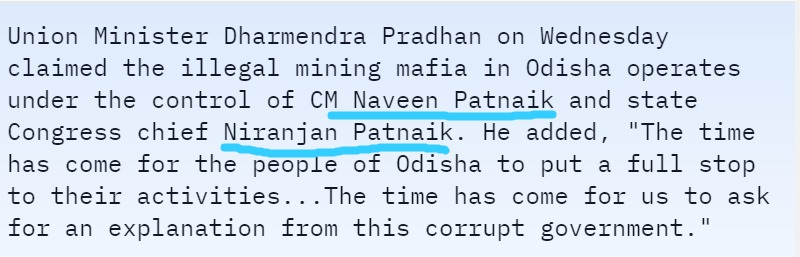

**Examples of where the llm does not know the real answer**

In [88]:
#First lets write a query for the LLM
query = """Who did call Modi "sir" 10 times?"""

co = cohere.Client(api_key=COHERE_API_KEY)
response = co.chat(
        model='command-r-plus',
        message=query,
    )
response.text

'US President Donald Trump'

In [42]:
#First lets write a query for the LLM
query = """Who did call Modi "sir" 10 times?"""

co = cohere.Client(api_key=COHERE_API_KEY)
response = co.chat(
        model='command-r-plus',
        message=query,
    )
response.text

'US President Donald Trump'

In [43]:
#First lets write a query for the LLM
query = """Who is the person that the Union Minister Dharmendra Pradhan claimed to be in control of the illegal mining mafia in Odisha?"""

co = cohere.Client(api_key=COHERE_API_KEY)
response = co.chat(
        model='command-r-plus',
        message=query,
    )
response.text

'Union Minister Dharmendra Pradhan claimed that Biju Janata Dal (BJD) leader and former MLA from Champua, Sanatan Mahakud, was the "remote control" of the illegal mining mafia in Odisha. He made this statement while addressing a public meeting in Kendujhargarh district, Odisha, on June 19, 2024. Pradhan accused the BJD-led state government of failing to curb illegal mining activities and alleged that Mahakud was orchestrating these operations from behind the scenes.'